#Importing Libraries

In [15]:
#Load Libraries
import pandas as pd
import numpy as np
import seaborn as sb
import keras as ks
import tensorflow as tf
import os
import pathlib
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import cm
%matplotlib inline

!gdown --id 1Q0HAXTixzFzl7eOAZbuXxrhvMCFMoRKL -O marchsample

Downloading...
From: https://drive.google.com/uc?id=1Q0HAXTixzFzl7eOAZbuXxrhvMCFMoRKL
To: /content/marchsample
583MB [00:09, 64.4MB/s]


In [3]:
#store everything in a dataframe
reddit_df = pd.read_json("marchsample",lines=True)
#shape of dataset
print("Shape of the dataset without preprocessing is ",reddit_df.shape)
#columns of dataset 
print("Columns in reddit dataset ", reddit_df.columns)
#statistical analysis of dataset
print(reddit_df.describe())
#types
print(reddit_df.dtypes)

Shape of the dataset without preprocessing is  (1000000, 18)
Columns in reddit dataset  Index(['ups', 'author_flair_text', 'gilded', 'author', 'created_utc', 'id',
       'score', 'distinguished', 'parent_id', 'retrieved_on', 'link_id',
       'author_flair_css_class', 'subreddit_id', 'body', 'subreddit',
       'stickied', 'controversiality', 'edited'],
      dtype='object')
                  ups          gilded  ...  controversiality        edited
count  1000000.000000  1000000.000000  ...    1000000.000000  1.000000e+06
mean         5.234093        0.000252  ...          0.023050  4.766906e+07
std         48.146464        0.017028  ...          0.150062  2.591869e+08
min       -429.000000        0.000000  ...          0.000000  0.000000e+00
25%          1.000000        0.000000  ...          0.000000  0.000000e+00
50%          1.000000        0.000000  ...          0.000000  0.000000e+00
75%          3.000000        0.000000  ...          0.000000  0.000000e+00
max       6046.000000

In [4]:
import numpy as np

np.sum((reddit_df["body"].apply(len)> 500) & (reddit_df["controversiality"]==1))
redditdflong = reddit_df[(reddit_df["body"].apply(len)> 1000)]
df_controversial_long = redditdflong[redditdflong["controversiality"]==1]
df_noncontroversial_long = redditdflong[redditdflong["controversiality"]==0].sample(536)
df_testbalanced = pd.concat([df_controversial_long, df_noncontroversial_long], axis=0)
df_testbalanced.shape

(1072, 18)

In [5]:
#dropping everything.
redditdf2 = df_testbalanced.drop(['author_flair_text', 'edited', 'parent_id', 'subreddit_id',
        'id', 'distinguished', 'retrieved_on', 'created_utc',
       'link_id', 'author_flair_css_class', 'stickied', 'gilded', 'author',
       'score', 'ups'], axis=1)
print(redditdf2.columns)

Index(['body', 'subreddit', 'controversiality'], dtype='object')


In [6]:
#removing [removed] section from the body part.
redditdf2_clean = redditdf2[~redditdf2['body'].str.contains('removed')]
redditdf2_clean.reset_index(drop=True, inplace=True)
redditdf2_clean.values

array([["HC is **not** to the left on income inequality, minimum wage, healthcare, financial reform, at all. She is most firmly entrenched with the banks and corporations that created it. Abortion rights, gay rights, and other social issues are just the bones she will throw to us. She doesn't support them, and has never supported them unless they were politically expedient for her. She'd toss them under a bus if it would get her votes. \n\nI don't know where you were in the 90's, and what you saw during the Clinton administration. What I saw was a non-stop capitulation of liberal values. It felt like every time it came to a showdown, the Dems capitulated. HC pushed healthcare reform in the first term. But she kept blinking, and waiting until '94, when the Rs took control of the house. Then she dropped it like a hot potato and it took *another 14 years* before the Dems would touch it again. So don't play me that snake oil. \n\n&gt; you cannot in good conscience abstain or vote GOP.\n\nI

In [7]:
reddit_train_clean_body = redditdf2_clean["body"]
reddit_train_clean_subreddit = redditdf2_clean["subreddit"]

def stripUrl(body):
    for start in ["ftp","http", "www"]:
        loc = body.find(start)
        while loc != -1:
            end = body.find(".com ",loc+1)
            if end == -1:
                end = body.find(".net ",loc+1)
            if end == -1:
                end = body.find(".org ",loc+1)
            if end == -1:
                end = body.find(".io ",loc+1)
            if end == -1:
                end = body.find(".win ",loc+1)
            if end == -1:
                end = body.find(" ",loc+1)
            if end == -1:
                loc = body.find(start,loc+1)
                continue
                
            L = list(body)
            L = L[:loc]+L[end+4:]
            body = "".join(L)
            loc = body.find(start,loc+1)
    return body



reddit_train_clean_body_new = reddit_train_clean_body.apply(stripUrl)
reddit_train_clean_body_new = reddit_train_clean_body_new.str.lower()

reddit_train_clean_body_new = reddit_train_clean_body_new.str.replace("'","")
reddit_train_clean_body_new = reddit_train_clean_body_new.str.replace("\n"," ")

reddit_train_clean_body_new = reddit_train_clean_body_new.str.replace('[^a-zA-Z0-9_]', ' ', regex=True)


print(reddit_train_clean_body_new)
print(reddit_train_clean_subreddit)

0       hc is   not   to the left on income inequality...
1          its more just a different kind of bigotry  ...
2       look  i had a whole thing typed out explaining...
3       making fun of people who complain is ridiculou...
4       it doesnt matter if we would not known about i...
                              ...                        
1028    maybe consider a different dog breed that does...
1029    nah  when i do my taxes every year my refund g...
1030    ive found myself referring to  this  site a lo...
1031        book read  greenmantle by john buchan   re...
1032        other subreddits   related links   icon li...
Name: body, Length: 1033, dtype: object
0              Liberal
1       ShitRedditSays
2                Games
3               cringe
4                  3DS
             ...      
1028              dogs
1029          Edmonton
1030              RATS
1031          hsupport
1032           houston
Name: subreddit, Length: 1033, dtype: object


In [8]:
from nltk.stem import WordNetLemmatizer

import nltk 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

stop_dict=set(['a','able','about','across','after','all','almost','also','am','among','an','and','any','are','as','at','be','because','been','but',
           'by','can','cannot','could','dear','did','do','does','either','else','ever','every','for','from','get','got','had','has','have','he',
           'her','hers','him','his','how','however','i','if','in','into','is','it','its','just','least','let','like','likely','may','me','might',
           'most','must','my','neither','no','nor','not','of','off','often','on','only','or','other','our','own','rather','said','say','says',
           'she','should','since','so','some','than','that','the','their','them','then','there','these','they','this','tis','to','too','twas',
           'us','wants','was','we','were','what','when','where','which','while','who','whom','why','will','with','would','yet','you','your'])

  
def lemmatize_and_stopwrds(body):
    S = ' '.join([lemmatizer.lemmatize(word) for word in body.split()])
    S = ' '.join([word for word in body.split() if word not in stop_dict])
    return S

reddit_train_clean_body_new = reddit_train_clean_body_new.apply(lemmatize_and_stopwrds)
print(reddit_train_clean_body_new)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
0       hc left income inequality minimum wage healthc...
1       more different kind bigotry lets forget specia...
2       look whole thing typed out explaining cut poin...
3       making fun people complain ridiculous complain...
4       doesnt matter known didnt see japanese version...
                              ...                        
1028    maybe consider different dog breed better heat...
1029    nah taxes year refund goes pay funny little st...
1030    ive found myself referring site lot researchin...
1031    book read greenmantle john buchan reader ios d...
1032    subreddits related links icon lightbulb genera...
Name: body, Length: 1033, dtype: object


In [ ]:
reddit_train_clean_body_new.iloc[100]

'president trump becomes reality january 20 2017 take remaining 11 months adjusting fact teddy roosevelt meets ronald reagan economic populism combined unprecedented understanding media surprise hes lived commercial end modern media landscape decades witnessed institutional changes news media cnn 80s 90s become understands media played better candidate perhaps president obama campaign trump denounces establishment two different ways skepticism immigration trade hell win south immigration rust belt trade hrc symbol politician claims act interests represents herself corporate interests behind teddy roosevelt win coalition two types economic populism against two partys base party out step those issues republican party voters go hillary turn out vote trump maybe few stay home blue collar workers rust belt cross parties vote trump instead hillary larger share black democratic voters republicans generation well add michigan wisconsin ohio pennsylvania romneys election hes 270 wins iowa virgi

In [9]:
redditdf2_clean.shape,reddit_train_clean_body_new.shape

((1033, 3), (1033,))

#Subreddit Numbering

In [10]:
subred = pd.Categorical(redditdf2_clean["subreddit"])
subred.codes

array([119, 189,  91, ..., 168, 361, 359], dtype=int16)

In [11]:
from sklearn.model_selection import train_test_split

import pandas as pd

subred = pd.Categorical(redditdf2_clean["subreddit"])

preX = np.c_[reddit_train_clean_body_new,subred.codes]

X_train,X_test,y_train,y_test = train_test_split(preX,redditdf2_clean["controversiality"])

X_train[2]

array(['much detracts game cut out half content make more rewarding care both side quests main story distracted side quests making stop caring story characters fact loose side stuff more linear quest lines more important characters far more entertaining story know ciri more vesemir unnecessary characters help jack reward play witcher 3 many characters meet know backstory development expected care many major characters entirely underdeveloped game many insignificant unnamed characters take up 100s hours game destracting getting character development bad design cd need learn cut back times push more more game make better longer',
       337], dtype=object)

In [18]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
tokenizer = ks.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(X_train[:,0])
X_train_tok = tokenizer.texts_to_matrix(X_train[:,0])
X_test_tok = tokenizer.texts_to_matrix(X_test[:,0])

X_train_final = np.c_[X_train_tok,X_train[:,1]]
X_test_final = np.c_[X_test_tok,X_test[:,1]]
X_test_final.shape, X_train_final.shape

((259, 20846), (774, 20846))

#Building Models

In [19]:
#Build models
models = []
#Logistic Regression
models.append(('LR',LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000)))
#KNN
models.append(('KNN',KNeighborsClassifier()))
#Classification and Regression Trees
models.append(('CART',DecisionTreeClassifier()))
#Support Vector Machine
models.append(('SVM',SVC(gamma='auto')))

#Evaluating each model
results = []
names = []
seed = 7
scores = []
stdevs = [] # keep stdev just in casea
for name, model in models:
  kfold = KFold(n_splits=10, random_state=seed)
  cv_results = cross_val_score(model,X_train_final, y_train,cv=kfold,scoring='accuracy')
  #cv_results = cross_val_score(model, Xpca_train, y_train,cv=kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s:%f (%f)" % (name, cv_results.mean(), cv_results.std())
  scores.append(cv_results.mean())
  stdevs.append(cv_results.std())
  print(msg)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR:0.701382 (0.059669)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN:0.574759 (0.057057)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART:0.627872 (0.064321)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM:0.570846 (0.042081)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.naive_bayes import MultinomialNB

model2 = MultinomialNB(alpha=10)
model2.fit(X_train_final,y_train)
MNB_score = model2.score(X_test_final, y_test)

clf = BernoulliNB()
clf.fit(X_train_final,y_train)
BNB_Score = clf.score(X_test_final,y_test)

print("Multinomial NB score is: ", MNB_score)
print("Bernoulli NB score is: ", BNB_Score)

results.append(MNB_score)
results.append(BNB_Score)
names.append("MNB")
names.append("BNB")

Multinomial NB score is:  0.6216216216216216
Bernoulli NB score is:  0.637065637065637


In [ ]:
del results[6]


In [21]:
print(results)
print(names)

scores.append(MNB_score)
scores.append(BNB_Score)

[array([0.62820513, 0.71794872, 0.80769231, 0.78205128, 0.7012987 ,
       0.74025974, 0.61038961, 0.67532468, 0.66233766, 0.68831169]), array([0.69230769, 0.61538462, 0.57692308, 0.55128205, 0.58441558,
       0.58441558, 0.58441558, 0.58441558, 0.46753247, 0.50649351]), array([0.66666667, 0.61538462, 0.69230769, 0.56410256, 0.63636364,
       0.75324675, 0.64935065, 0.51948052, 0.57142857, 0.61038961]), array([0.61538462, 0.58974359, 0.62820513, 0.61538462, 0.54545455,
       0.5974026 , 0.54545455, 0.49350649, 0.54545455, 0.53246753]), 0.6216216216216216, 0.637065637065637]
['LR', 'KNN', 'CART', 'SVM', 'MNB', 'BNB']


# Boxplots

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


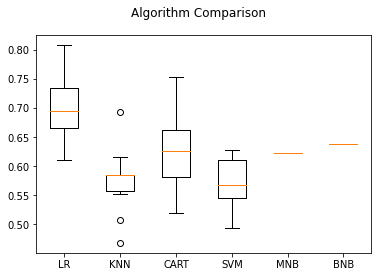

In [22]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
#plt.boxplot(results, MNB_score, BNB_Score)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


In [ ]:
print(names)

['LR', 'KNN', 'CART', 'SVM', 'MNB', 'BNB']


In [ ]:
LR = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000)
LR.fit (X_train_final, y_train)
predictions = LR.predict (X_test_final)
print(accuracy_score(y_test, predictions))
print(confusion_matrix (y_test, predictions))
print(classification_report(y_test, predictions))

0.6984732824427481
[[ 80  48]
 [ 31 103]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       128
           1       0.68      0.77      0.72       134

    accuracy                           0.70       262
   macro avg       0.70      0.70      0.70       262
weighted avg       0.70      0.70      0.70       262



In [ ]:
#Definition of the DNN model
from keras.models import Sequential
from keras.layers import Dense


model3 = Sequential()

#model3.add(BatchNormalization())
#model3.add(BatchNormalization())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(43, activation='softmax'))

#Compilation of the model
model3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
New_X_test_final = np.asarray(X_test_final).astype(np.float32)
New_y_test = np.asarray(y_test).astype(np.float32)
epochs = 20
history = model3.fit(X_train_final, y_train, batch_size=16, epochs=epochs,
validation_data=(New_X_test_final, New_y_test))

#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

ValueError: ignored

#Only use if there are memory issue

In [ ]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components = 100)
Xpca_train = tsvd.fit_transform(X_train_final) ## autocentered
Xpca_test =  tsvd.transform(X_test_final) ## autocentered
Xpca_train.shape

In [ ]:
clf.fit(Xpca_train,y_train)

clf.score(Xpca_test,y_test)

0.5637065637065637